In [1]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.utils import shuffle

# Load and Resize Image

(192, 128, 3)


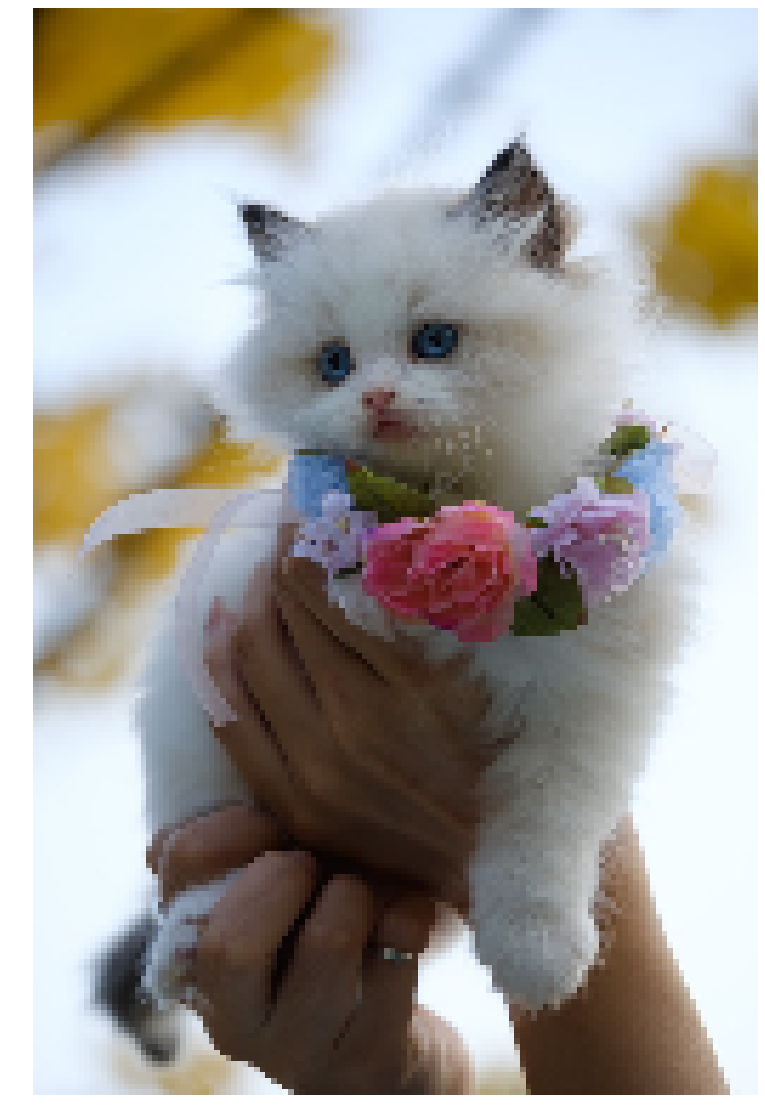

In [2]:
img_path = 'img/01.jpg'
img = cv2.imread(img_path)

img = cv2.resize(img, dsize=None, fx=0.2, fy=0.2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

# Load and Preview Patch Images (CiFAR-10)

(50000, 32, 32, 3)


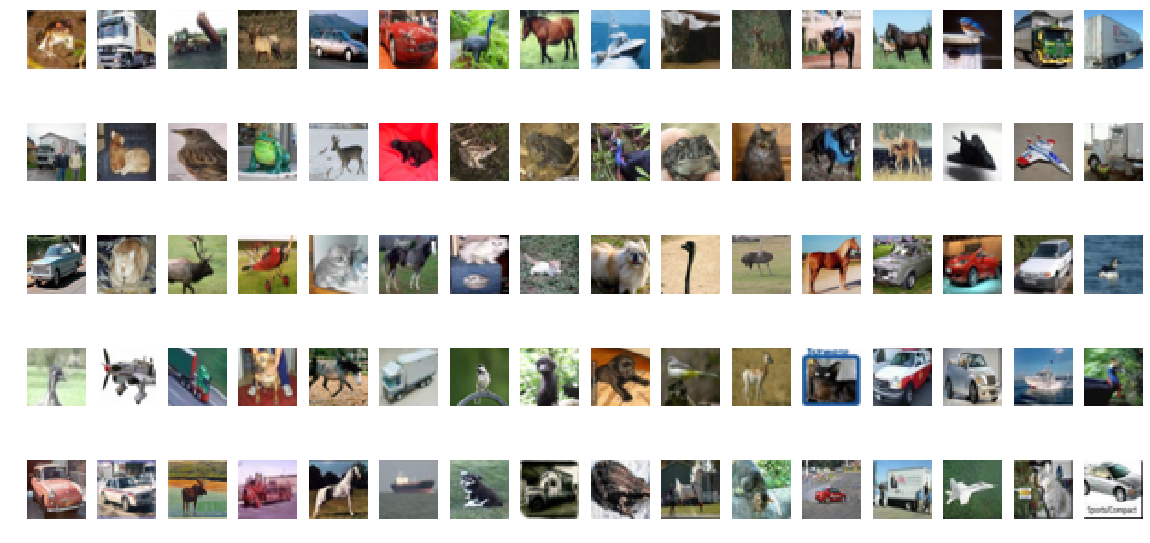

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        
    data = dict[b'data'].reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1).astype(np.float64) / 255.

    return data

x_train_1 = unpickle('dataset/data_batch_1')
x_train_2 = unpickle('dataset/data_batch_2')
x_train_3 = unpickle('dataset/data_batch_3')
x_train_4 = unpickle('dataset/data_batch_4')
x_train_5 = unpickle('dataset/data_batch_5')

sample_imgs = np.concatenate([x_train_1, x_train_2, x_train_3, x_train_4, x_train_5], axis=0)

print(sample_imgs.shape)

plt.figure(figsize=(20, 10))
for i in range(80):
    img_patch = sample_imgs[i]

    plt.subplot(5, 16, i+1)
    plt.axis('off')
    plt.imshow(img_patch)

# KMean Clustering for Image Quantization

In [4]:
N_CLUSTERS = 32

h, w, d = img.shape

img_array = img.copy().astype(np.float64) / 255.
img_array = np.reshape(img_array, (w * h, d))

# all pixels
img_array_sample = shuffle(img_array, random_state=0)

# pick random 1000 pixels if want to run faster
# img_array_sample = shuffle(img_array, random_state=0)[:1000]

# KMeans clustering
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(img_array_sample)

print(kmeans.cluster_centers_)

[[0.94889892 0.98544753 0.99859422]
 [0.6109274  0.52210917 0.42965554]
 [0.20197816 0.14197595 0.0997709 ]
 [0.67625208 0.71117327 0.7722868 ]
 [0.57187166 0.42320143 0.00926916]
 [0.38875148 0.29376635 0.24352439]
 [0.82780868 0.86452049 0.91653907]
 [0.61127526 0.60571224 0.60028054]
 [0.3037781  0.22438546 0.17375897]
 [0.4626646  0.3312748  0.01484676]
 [0.31214421 0.44320051 0.62213789]
 [0.41396869 0.40279171 0.41713026]
 [0.89892241 0.95546116 0.99627683]
 [0.71623826 0.64335146 0.51789422]
 [0.75308497 0.76040959 0.76932462]
 [0.66938646 0.51872233 0.05752056]
 [0.61278645 0.64724371 0.69766944]
 [0.77549834 0.80744307 0.85301328]
 [0.86295111 0.91729144 0.98253811]
 [0.24921613 0.1794006  0.13325294]
 [0.11093814 0.06822343 0.04509433]
 [0.53432154 0.57249898 0.62947744]
 [0.52102338 0.52557827 0.53673482]
 [0.59082925 0.47941176 0.19485294]
 [0.46552455 0.46527471 0.47686542]
 [0.59388545 0.28581011 0.37770898]
 [0.2833768  0.27308993 0.27234618]
 [0.72127731 0.70056246 0.67

# Plot Quantized Image

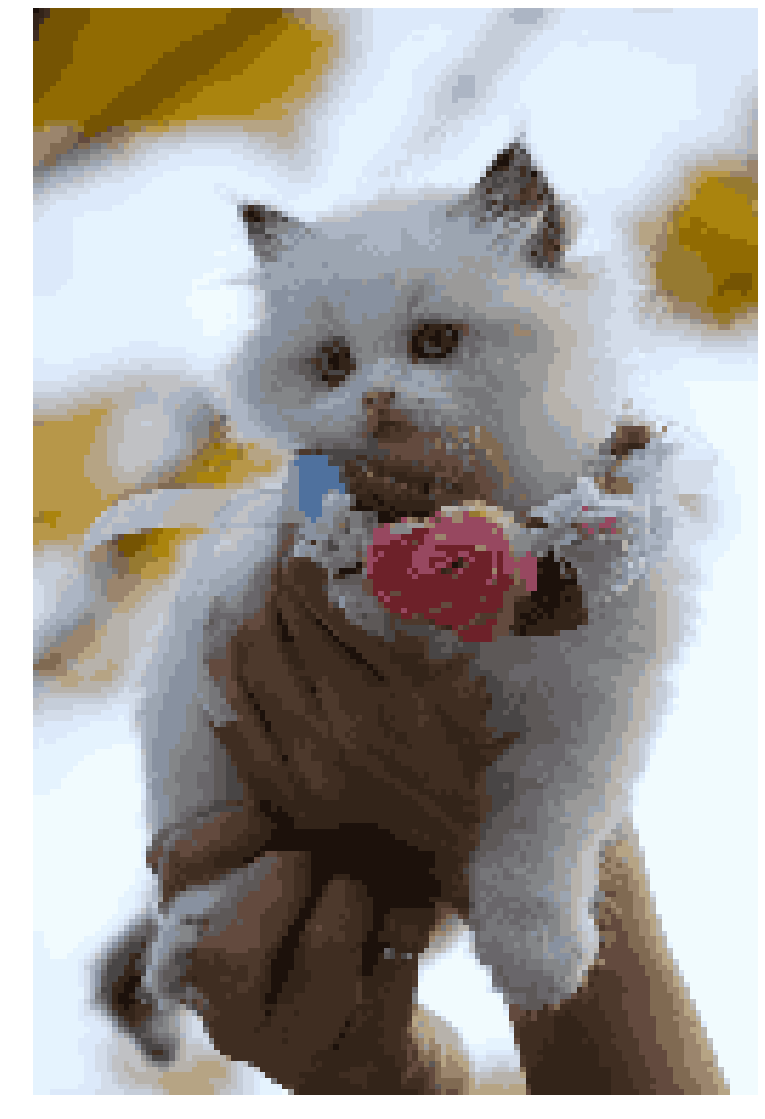

In [5]:
cluster_centers = kmeans.cluster_centers_

pred_labels = kmeans.predict(img_array)
cluster_labels = pred_labels.reshape((h, w))

img_quantized = np.zeros((h, w, d), dtype=np.float64)

label_idx = 0
for y in range(h):
    for x in range(w):
        label = pred_labels[label_idx]

        img_quantized[y, x] = cluster_centers[label]

        label_idx += 1

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img_quantized)

# Compute Distance of Pixels and Patches

In [6]:
DISTANCE_THRESHOLD = 0.1

bins = defaultdict(list)

for img_patch in sample_imgs:
    mean = np.mean(img_patch, axis=(0, 1))

    # compare patch mean and cluster centers
    cluster_idx, distance = pairwise_distances_argmin_min(cluster_centers, [mean], axis=0)
    
    if distance < DISTANCE_THRESHOLD:
        bins[cluster_idx[0]].append(img_patch)

# number of bins must equal to N_CLUSTERS. if not, increase DISTANCE_THRESHOLD
assert(len(bins) == N_CLUSTERS)

# Fill Images

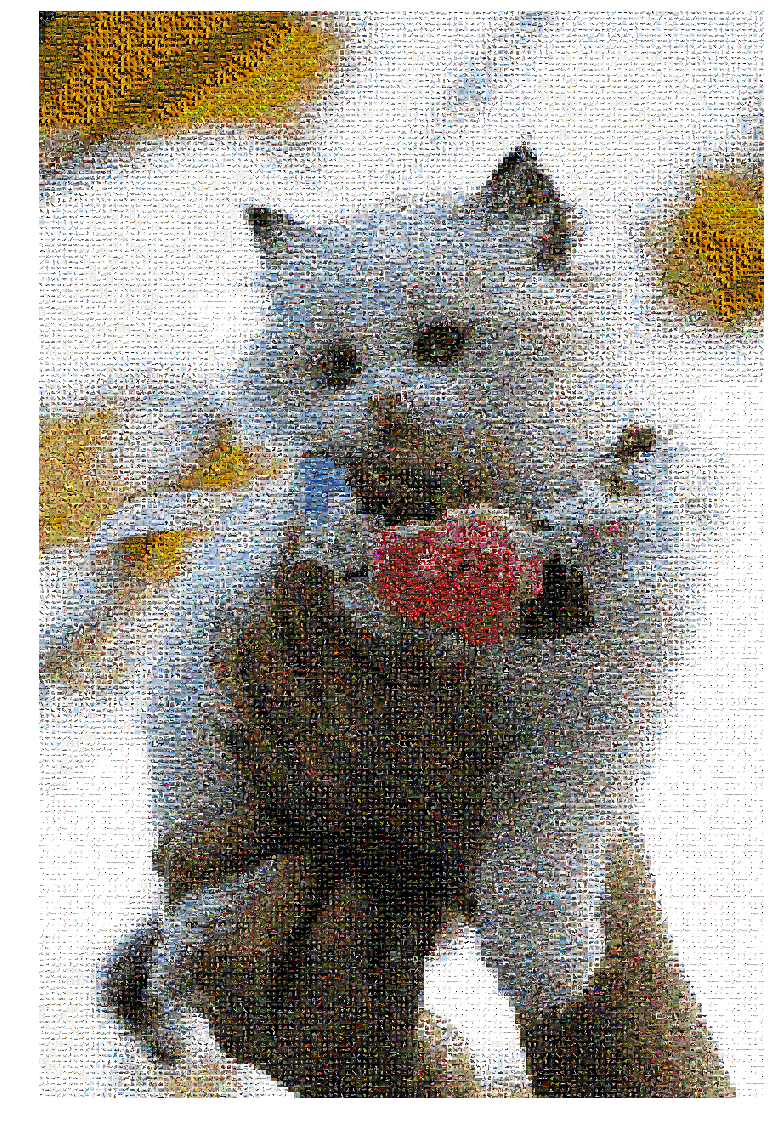

In [7]:
img_out = np.zeros((h*32, w*32, d), dtype=np.float64)

for y in range(h):
    for x in range(w):
        label = cluster_labels[y, x]

        b = bins[label]

        img_patch = b[np.random.randint(len(b))]

        img_out[y*32:(y+1)*32, x*32:(x+1)*32] = img_patch
        
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img_out)

img_out2 = cv2.cvtColor((img_out * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
_ = cv2.imwrite('result/%s_color.jpg' % os.path.splitext(os.path.basename(img_path))[0], img_out2)